# Machine Learning Applied to Professional Football: Performance Improvement and Results Prediction

## ---> Case Studies of Application of ML in Professional Football

### Predicting the Date Cristiano Ronaldo will Reach 1000 Goals

In [27]:
# Import core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import machine learning and deep learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Data and Methodology

In [28]:
df = pd.read_csv('Historial goles.csv')

In [29]:
df['Date'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df['Year']       = df['Date'].dt.year
df['Month']      = df['Date'].dt.month
df['YearMonth']  = df['Date'].dt.to_period('M')   
df['DateNum'] = (df['Date'] - df['Date'].min()).dt.days
df = df.drop(columns=['DATE'])
print(df)

     GOALS             TEAM       Date  Year  Month YearMonth  DateNum
0        1      Sporting CP 2002-10-07  2002     10   2002-10        0
1        2      Sporting CP 2002-10-07  2002     10   2002-10        0
2        3      Sporting CP 2002-10-26  2002     10   2002-10       19
3        4  Sporting Lisboa 2002-11-24  2002     11   2002-11       48
4        5  Sporting Lisboa 2002-12-18  2002     12   2002-12       72
..     ...              ...        ...   ...    ...       ...      ...
948    949         Al-Nassr 2025-08-24  2025      8   2025-08     8357
949    950         Al-Nassr 2025-10-19  2025     10   2025-10     8413
950    951         Al-Nassr 2025-10-26  2025     10   2025-10     8420
951    952         Al-Nassr 2025-11-02  2025     11   2025-11     8427
952    953         Al-Nassr 2025-11-08  2025     11   2025-11     8433

[953 rows x 7 columns]


In [30]:
# Group goals by year
goals_by_year = df.groupby('Year').size()
print("\nGoals by year:")
print(goals_by_year)

# Group goals by year and month
monthly_goals = df.groupby('YearMonth').size().reset_index()
monthly_goals.columns = ['YearMonth', 'Goals']
monthly_goals['YearMonth'] = monthly_goals['YearMonth'].astype(str)
monthly_goals['Date'] = pd.to_datetime(monthly_goals['YearMonth'])
monthly_goals = monthly_goals.sort_values('Date')

# Reset index
monthly_goals.reset_index(drop=True, inplace=True)


Goals by year:
Year
2002     5
2003     1
2004    13
2005    15
2006    25
2007    34
2008    35
2009    30
2010    48
2011    60
2012    63
2013    69
2014    61
2015    57
2016    55
2017    53
2018    49
2019    39
2020    44
2021    47
2022    16
2023    54
2024    43
2025    37
dtype: int64


In [31]:
# Prepare Data for Forecasting Models
# Create data for monthly prediction
monthly_data = monthly_goals.copy()
monthly_data['time'] = range(len(monthly_data))

# Determine cutoff point for training (70%) and test (30%)
cutoff = int(len(monthly_data) * 0.7)
train_data = monthly_data.iloc[:cutoff].copy()
test_data = monthly_data.iloc[cutoff:].copy()

# Make sure indices are correct
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(f"\nTotal current goals: {len(df)}")
print(f"Goals remaining to reach 1000: {1000 - len(df)}")


Total current goals: 953
Goals remaining to reach 1000: 47


In [32]:
# Global variables for results
last_period = monthly_data['Date'].max()
total_current_goals = len(df)
prediction_results = {}
model_metrics = {}

# Function to calculate prediction metrics
def calculate_metrics(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    # MAPE (Mean Absolute Percentage Error)
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

# Function to predict when 1000 goals will be reached
def predict_1000_goals(model_name, monthly_predictions):
    accumulated_goals = total_current_goals
    current_date = last_period
    future_predictions = []

    month = 0
    while accumulated_goals < 1000:
        month += 1
        current_date = current_date + relativedelta(months=1)
        if month <= len(monthly_predictions):
            month_goals = max(0, round(monthly_predictions[month-1]))
        else:
            # If we run out of predictions, use the average of the last 6
            last_6 = monthly_predictions[max(0, month-7):month-1]
            if len(last_6) > 0:
                month_goals = max(0, round(np.mean(last_6)))
            else:
                month_goals = 5  # Default value if there is no data

        accumulated_goals += month_goals
        year_month = current_date.strftime('%Y-%m')
        future_predictions.append({
            'Model': model_name,
            'Date': current_date,
            'YearMonth': year_month,
            'Goals': month_goals,
            'Accumulated': accumulated_goals
        })

    return pd.DataFrame(future_predictions)

In [33]:
# Function to format the prediction date
def format_prediction_date(date):
    return date.strftime('%Y-%m')
# Prepare data to train models
X_train = train_data[['time']]
y_train = train_data['Goals']
# Create test data
X_test = test_data[['time']]
y_test = test_data['Goals']
# Create data for prediction
last_time = monthly_data['time'].max()
future_times = np.array(range(last_time + 1, last_time + 37)).reshape(-1, 1)

In [34]:
# 1. RandomForest Model
print("Training RandomForest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Test on test set
y_pred_rf_test = rf_model.predict(X_test)
y_pred_rf_test = np.maximum(y_pred_rf_test, 0)  # No negative predictions

# Calculate metrics
rf_metrics = calculate_metrics(y_test.values, y_pred_rf_test, 'RandomForest')
model_metrics['RandomForest'] = rf_metrics

# Predict with RandomForest for future
pred_rf = rf_model.predict(future_times)
pred_rf = np.maximum(pred_rf, 0)

# Predict when it will reach 1000 goals
rf_df = predict_1000_goals('RandomForest', pred_rf)
rf_date = rf_df.iloc[-1]['Date']
prediction_results['RandomForest'] = format_prediction_date(rf_date)

Training RandomForest model...


In [35]:
# 3. XGBoost Model with Temporal Features
print("Training XGBoost model with temporal features...")
try:
    # Create additional temporal features to improve the model
    def create_temporal_features(df):
        df_feat = df.copy()
        # Extract time components from date
        df_feat['year'] = df_feat['Date'].dt.year
        df_feat['month'] = df_feat['Date'].dt.month
        df_feat['quarter'] = df_feat['Date'].dt.quarter
        df_feat['day_of_year'] = df_feat['Date'].dt.dayofyear

        # Create cyclical features for month
        df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month']/12)
        df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month']/12)

        # Temporal trend
        if len(df_feat) > 1:
            # Calculate trend from recent periods
            df_feat['trend'] = df_feat['time'].diff().fillna(1)
        else:
            df_feat['trend'] = 1

        return df_feat

    # Apply transformation to training data
    train_data_xgb = create_temporal_features(train_data)

    # Select features for XGBoost
    features_xgb = ['time', 'year', 'month', 'quarter', 'day_of_year', 'month_sin', 'month_cos', 'trend']
    X_train_xgb = train_data_xgb[features_xgb]
    y_train_xgb = train_data_xgb['Goals']

    # Apply transformation to test data
    test_data_xgb = create_temporal_features(test_data)
    X_test_xgb = test_data_xgb[features_xgb]
    y_test_xgb = test_data_xgb['Goals']

    # Create and train XGBoost model
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        objective='reg:squarederror',
        random_state=42
    )
    xgb_model.fit(X_train_xgb, y_train_xgb)

    # Test XGBoost on test set
    y_pred_xgb_test = xgb_model.predict(X_test_xgb)
    y_pred_xgb_test = np.maximum(y_pred_xgb_test, 0)  # No negative predictions

    # Calculate metrics
    xgb_metrics = calculate_metrics(y_test_xgb.values, y_pred_xgb_test, 'XGBoost')
    model_metrics['XGBoost'] = xgb_metrics

    # Prepare data for future prediction
    future_dates = [last_period + relativedelta(months=i+1) for i in range(36)]
    future_times_xgb = range(last_time + 1, last_time + 37)

    # Create DataFrame with future dates
    future_df = pd.DataFrame({
        'Date': future_dates,
        'time': future_times_xgb
    })

    # Apply the same transformation to future data
    future_df_xgb = create_temporal_features(future_df)
    X_future_xgb = future_df_xgb[features_xgb]

    # Make prediction
    pred_xgb = xgb_model.predict(X_future_xgb)
    pred_xgb = np.maximum(pred_xgb, 0)  # Ensure there are no negative values

    # Predict when it will reach 1000 goals
    xgb_df = predict_1000_goals('XGBoost', pred_xgb)
    xgb_date = xgb_df.iloc[-1]['Date']
    prediction_results['XGBoost'] = format_prediction_date(xgb_date)

except Exception as e:
    print(f"Error in XGBoost model: {e}")
    # Create a simplified prediction
    pred_xgb = np.array([train_data['Goals'].mean() * 1.05] * 36)
    xgb_df = predict_1000_goals('XGBoost (Simplified)', pred_xgb)
    xgb_date = xgb_df.iloc[-1]['Date']
    prediction_results['XGBoost'] = format_prediction_date(xgb_date)

    # Metrics
    model_metrics['XGBoost'] = {
        'Model': 'XGBoost (Simplified)',
        'MSE': np.nan,
        'RMSE': np.nan,
        'MAE': np.nan,
        'MAPE': np.nan,
        'R²': np.nan
    }

Training XGBoost model with temporal features...


In [36]:
# Combine all prediction results
all_df = pd.concat([rf_df, xgb_df], ignore_index=True)

# Create a dataframe with all metrics
metrics_df = pd.DataFrame(model_metrics.values())
print("\n======= MODEL PERFORMANCE METRICS =======")
print(metrics_df.set_index('Model').round(3))


======= MODEL PERFORMANCE METRICS =======
                MSE   RMSE    MAE    MAPE     R²
Model                                           
RandomForest  6.919  2.630  2.098  58.254 -0.403
XGBoost       6.696  2.588  2.123  68.226 -0.357


### Visualization

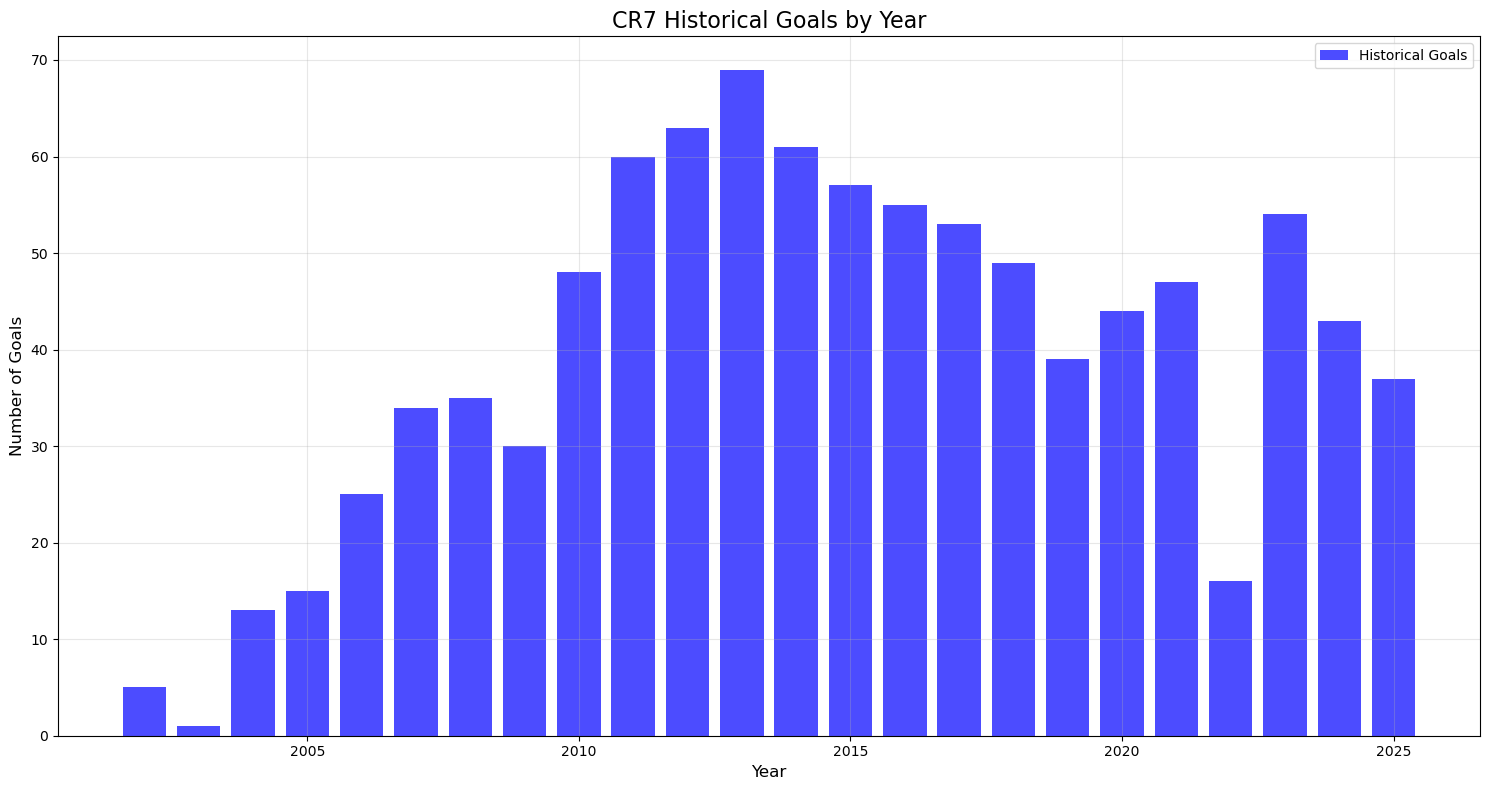

In [37]:
# Plot 1: Historical goals by year
plt.figure(figsize=(15, 8))

years = sorted(df['Year'].unique())
historical_goals = [df[df['Year'] == year].shape[0] for year in years]
plt.bar(years, historical_goals, color='blue', alpha=0.7, label='Historical Goals')

plt.title('CR7 Historical Goals by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Goals', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

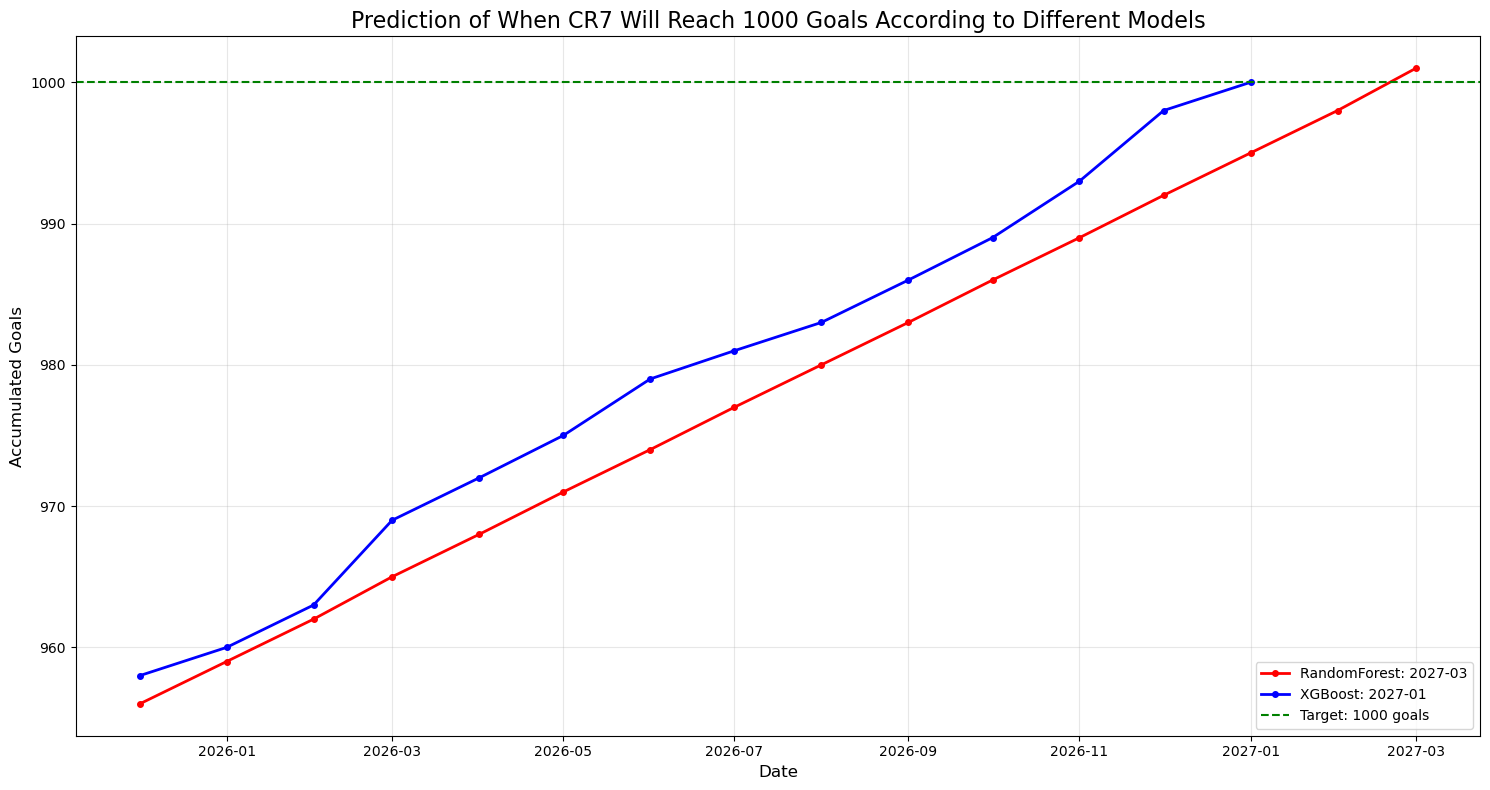

In [38]:
# Plot 2: Monthly predictions by model
plt.figure(figsize=(15, 8))

# Use model names that actually exist in the DataFrame
models_df = all_df['Model'].unique()
colors = ['red', 'blue']

for i, model in enumerate(models_df):
    color_idx = min(i, len(colors) - 1)  # Avoid out-of-range indices
    model_df = all_df[all_df['Model'] == model]

    # Extract base model name (in case we have simplified versions)
    base_name = model.split(' ')[0]
    if base_name not in prediction_results:
        base_name = model  # Use full name if we can't find the base

    plt.plot(model_df['Date'], model_df['Accumulated'], marker='o', markersize=4,
             linewidth=2, color=colors[color_idx],
             label=f'{base_name}: {prediction_results.get(base_name, "N/A")}')

plt.axhline(y=1000, color='green', linestyle='--', label='Target: 1000 goals')
plt.title('Prediction of When CR7 Will Reach 1000 Goals According to Different Models', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accumulated Goals', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



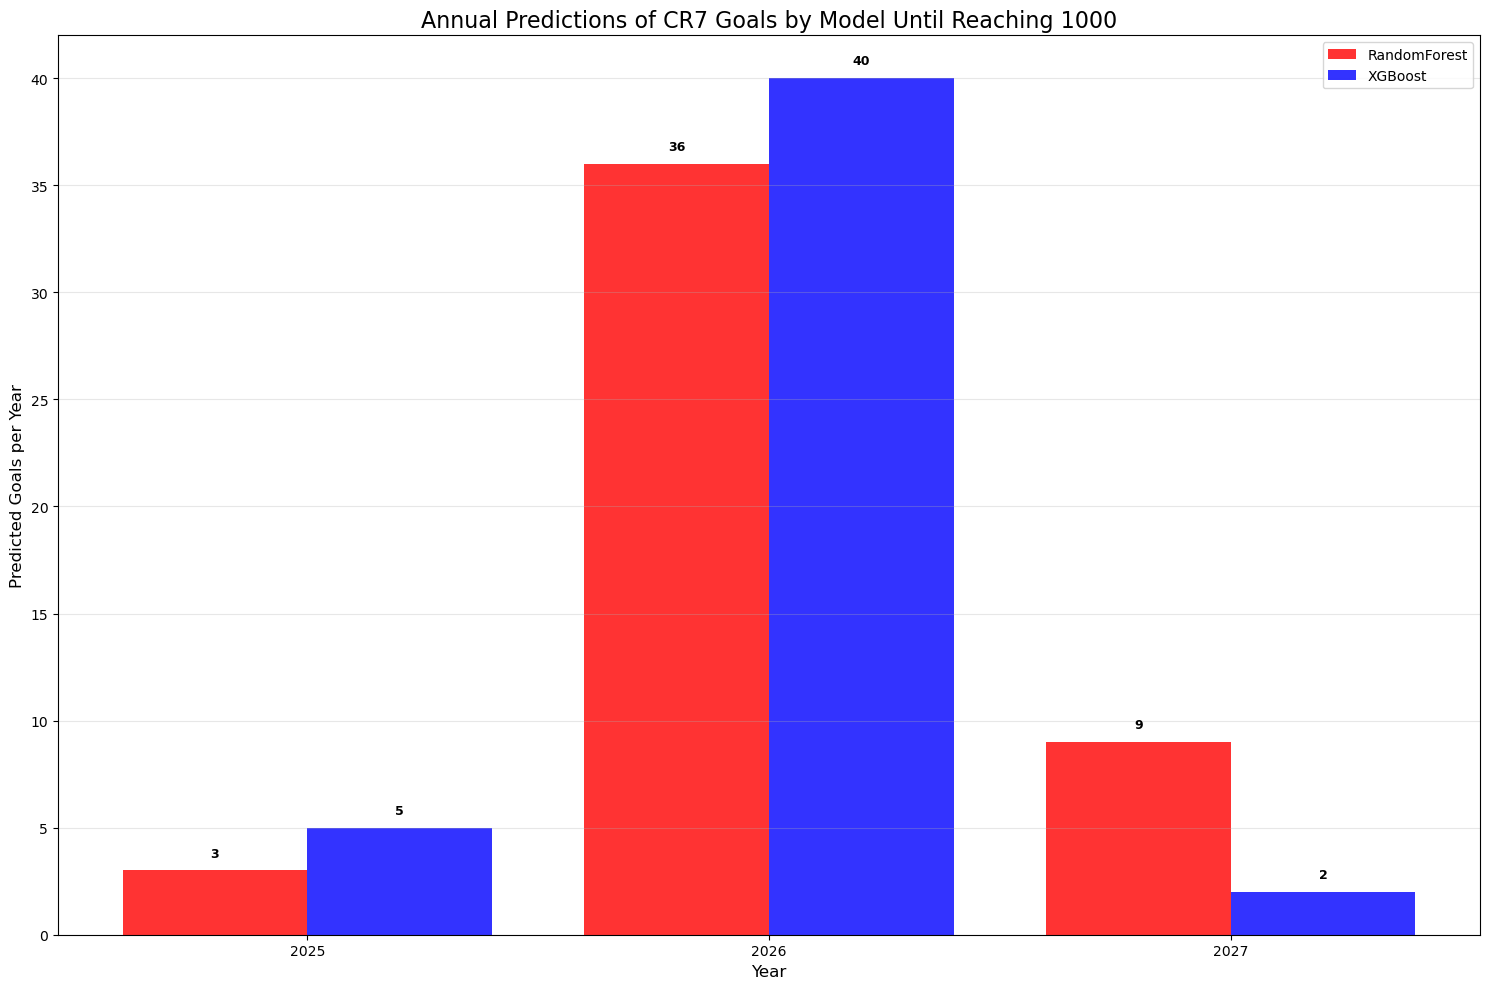

In [39]:
# Plot 3: Annual predictions of CR7 goals by model unitl reaching 1000 goals.
plt.figure(figsize=(15, 10))

# Group predictions by year and model
annual_pred = {}
for model in models_df:
    model_df = all_df[all_df['Model'] == model]
    # Group goals by year for each model
    pred_by_year = model_df.groupby(model_df['Date'].dt.year)['Goals'].sum().reset_index()
    pred_by_year.columns = ['Year', 'Goals']
    annual_pred[model] = pred_by_year

# Find all unique years in predictions
all_years = set()
for model in models_df:
    for year in annual_pred[model]['Year'].values:
        all_years.add(year)
all_years = sorted(list(all_years))

# Calculate width of each bar
n_models = len(models_df)
group_width = 0.8  # total width available for each year
bar_width = group_width / n_models
offsets = [i*bar_width - group_width/2 + bar_width/2 for i in range(n_models)]


for i, model in enumerate(models_df):
    color_idx = min(i, len(colors) - 1)
    years = annual_pred[model]['Year'].values
    goals = annual_pred[model]['Goals'].values

    # Create adjusted positions for each bar
    positions = [year + offsets[i] for year in years]

    # Plot the bars
    bars = plt.bar(positions, goals, width=bar_width, color=colors[color_idx],
                   label=model, alpha=0.8)

    # Add text labels above each bar with the number of goals
    for j, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                 f'{int(round(goals[j]))}',  # Round to integer for better visualization
                 ha='center', va='bottom', fontweight='bold', fontsize=9)

# Additional chart configuration
plt.title('Annual Predictions of CR7 Goals by Model Until Reaching 1000', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Predicted Goals per Year', fontsize=12)
plt.xticks(all_years)  # Ensure years appear correctly on x-axis
plt.grid(True, alpha=0.3, axis='y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('cr7_prediction_annual_goals_by_model.png')
plt.show()

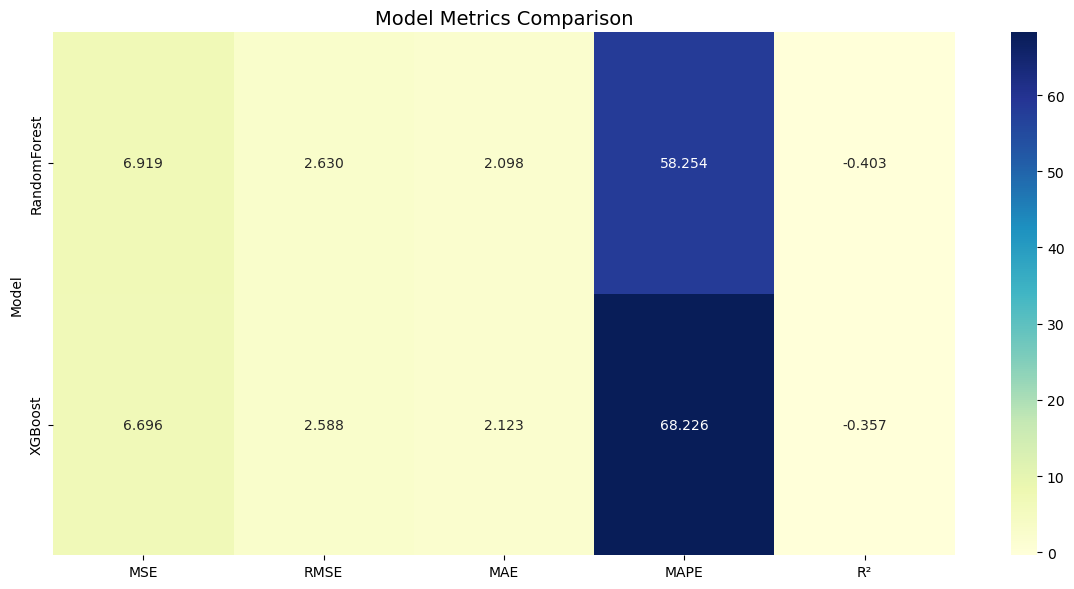

In [40]:
# Plot 4: Heatmap of model metrics
plt.figure(figsize=(12, 6))
metrics_for_heatmap = metrics_df.copy()
metrics_for_heatmap = metrics_for_heatmap.set_index('Model')
# Select numerical columns and convert to float
numerical_cols = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²']
metrics_for_heatmap = metrics_for_heatmap[numerical_cols].astype(float)

# Create heatmap
sns.heatmap(metrics_for_heatmap, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Metrics Comparison', fontsize=14)
plt.tight_layout()
plt.savefig('cr7_model_metrics_heatmap.png')
plt.show()

In [41]:
# Show final results
print("\n=============== FINAL RESULTS ===============")
for model, date in prediction_results.items():
    # Add model metrics to the output
    metrics_str = ""
    if model in model_metrics:
        metrics = model_metrics[model]
        if not np.isnan(metrics['RMSE']) and not np.isnan(metrics['R²']):
            metrics_str = f" (RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R²']:.3f})"

    print(f"CR7 will reach 1000 goals according to {model} in: {date}{metrics_str}")

# Find the best model based on metrics
best_model = None
best_score = float('-inf')

for model in model_metrics:
    # Use a combination of metrics for scoring (lower RMSE and higher R² is better)
    if not np.isnan(model_metrics[model]['RMSE']) and not np.isnan(model_metrics[model]['R²']):
        score = -model_metrics[model]['RMSE'] + model_metrics[model]['R²'] * 10
        if score > best_score:
            best_score = score
            best_model = model

if best_model:
    print(f"\nBest model based on evaluation metrics: {best_model}")
    print(f"Estimated date to reach 1000 goals according to {best_model}: {prediction_results.get(best_model, 'N/A')}")


=============== FINAL RESULTS ===============
CR7 will reach 1000 goals according to RandomForest in: 2027-03 (RMSE: 2.63, R²: -0.403)
CR7 will reach 1000 goals according to XGBoost in: 2027-01 (RMSE: 2.59, R²: -0.357)

Best model based on evaluation metrics: XGBoost
Estimated date to reach 1000 goals according to XGBoost: 2027-01


In [41]:
# Show final results
print("\n=============== FINAL RESULTS ===============")
for model, date in prediction_results.items():
    # Add model metrics to the output
    metrics_str = ""
    if model in model_metrics:
        metrics = model_metrics[model]
        if not np.isnan(metrics['RMSE']) and not np.isnan(metrics['R²']):
            metrics_str = f" (RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R²']:.3f})"

    print(f"CR7 will reach 1000 goals according to {model} in: {date}{metrics_str}")

# Find the best model based on metrics
best_model = None
best_score = float('-inf')

for model in model_metrics:
    # Use a combination of metrics for scoring (lower RMSE and higher R² is better)
    if not np.isnan(model_metrics[model]['RMSE']) and not np.isnan(model_metrics[model]['R²']):
        score = -model_metrics[model]['RMSE'] + model_metrics[model]['R²'] * 10
        if score > best_score:
            best_score = score
            best_model = model

if best_model:
    print(f"\nBest model based on evaluation metrics: {best_model}")
    print(f"Estimated date to reach 1000 goals according to {best_model}: {prediction_results.get(best_model, 'N/A')}")


=============== FINAL RESULTS ===============
CR7 will reach 1000 goals according to RandomForest in: 2027-03 (RMSE: 2.63, R²: -0.403)
CR7 will reach 1000 goals according to XGBoost in: 2027-01 (RMSE: 2.59, R²: -0.357)

Best model based on evaluation metrics: XGBoost
Estimated date to reach 1000 goals according to XGBoost: 2027-01


### Results and Evaluation